In [1]:
import sys
import yaml
sys.path.append('../')
import os
import torch
from misc import yaml_util as yu
sys.path.append('../dataset')
sys.path.append('../module')
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca


In [131]:
datname = 'OneDsignal_c8mimic'
#datname = 'OneDCyclic'
#modelname = 'fordebug'
#modelname = 'mlp1layer_nonDim'
modelname = 'mask1layer'

trainname = 'baseline'
with open(f'''../cfg_data/{datname}.yaml''', 'rb') as f:
    cfg_data = yaml.safe_load(f)

cfg_data['args']['shift_label'] = True
cfg_data['args']['freq_manual'] = [0, 2, 10]
cfg_data['args']['nfreq'] = len(cfg_data['args']['freq_manual']) 

mydata = yu.load_component(cfg_data) 

myloader = DataLoader(mydata, batch_size=20,
                        shuffle=False, 
                        num_workers=1,
                        )


seq, shift =  mydata[0]
seq = seq[None, :]
print(seq.shape)

expname = f'''{datname}_{modelname}_{trainname}'''

exppath = os.path.join("../dnftresult", expname)
if not os.path.exists(exppath):
    raise NotImplementedError
mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)
mymodel = mymodel.to(0)
mymodel

./dataset/oneDsignal_data.py
[0, 2, 10]
0
torch.Size([1, 3, 128])


NFT(
  (encoder): MLPEncoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): Linear(in_features=128, out_features=130, bias=True)
      (1): MaskFlatLinear()
      (2): Tanh()
      (3): MaskFlatLinear()
      (4): Tanh()
      (5): MaskFlatLinear()
    )
  )
  (decoder): MLPDecoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): MaskFlatLinear()
      (1): Tanh()
      (2): MaskFlatLinear()
      (3): Tanh()
      (4): MaskFlatLinear()
      (5): Linear(in_features=130, out_features=128, bias=True)
    )
  )
)

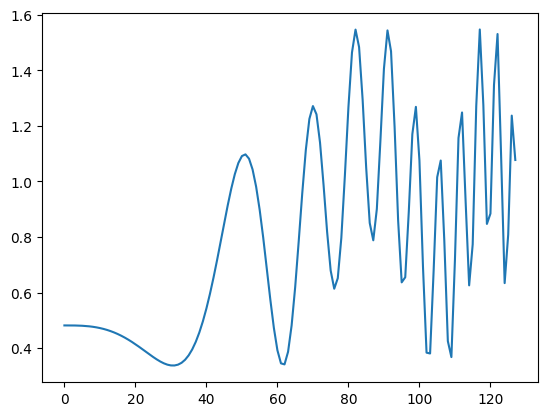

In [132]:
plt.plot(seq[0,0])

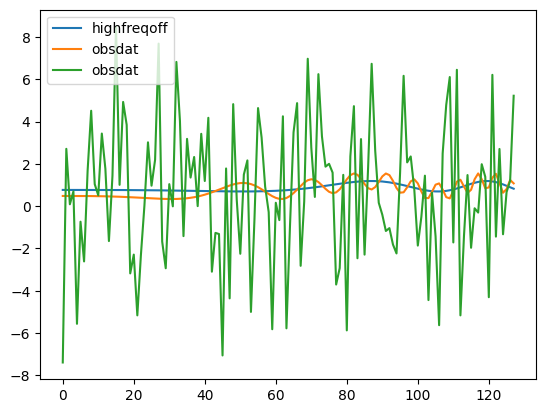

In [133]:
import numpy as np
import math
coefstar = mydata.coefs[0] * np.array([1, 1, 0 ] )
dt = 1.0 / mydata.N

freq = mydata.freqs[0, :]


obs_t = np.arange(0, mydata.N * dt, dt)  # observed time  [0,1]/N
lat_t = np.power(obs_t, mydata.pow)  # observed time domain: lat_t = obs_t^pow

for t in range(1):  # shift * t ( action up to T times)
    lat_t = np.power(obs_t, mydata.pow) - t * shift / (2 * math.pi)
    lat_t = lat_t + (lat_t < 0) * (1.0)
    fobs_t = np.matmul(
        np.cos(np.outer(2 * np.pi * lat_t, freq))
        + np.sin(np.outer(2 * np.pi * lat_t, freq)),
        coefstar,
    )  # fn_t(j) = f_lat((t_j)**pow - shift*t)

plt.plot(fobs_t, label= 'highfreqoff') 
plt.plot(seq[0,0],  label = 'obsdat')

ep = torch.normal(mean=torch.zeros(size=seq[0,0].shape), std=3.0)
plt.plot(seq[0,0] + ep,  label = 'obsdat')

plt.legend()

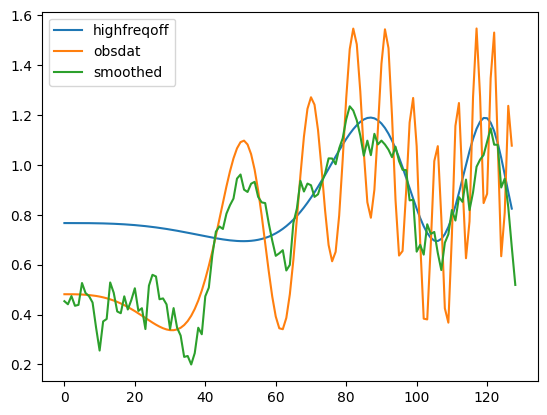

In [166]:
import torch.nn.functional as F

def do_smooth(vector, kernel_size=40):
    kernel = torch.ones(1, 1, kernel_size) / kernel_size
    # Apply the convolution
    smoothed_vector = F.conv1d(vector[None, :].float(), kernel, padding=kernel_size//2)
    # Reshape back to the original 128-dimensional vector
    smoothed_vector = smoothed_vector.view(-1)
    return smoothed_vector

plt.plot(fobs_t, label= 'highfreqoff') 
plt.plot(seq[0,0],  label = 'obsdat')

ep = torch.normal(mean=torch.zeros(size=seq[0,0].shape), std=0.5)
plt.plot(do_smooth(seq[0, 0] + ep, kernel_size=10) , label = 'smoothed')
plt.legend()


In [173]:
import time

# Get the current time
current_time = time.localtime()

# Format the time to only include the date (Year-Month-Day)
current_date = time.strftime("%Y-%m-%d-%H:%M", current_time)

In [174]:
current_date

'2024-08-22-09:03'